# Readout & Resonators

Let's use this notebook to explore a handful of concepts that are useful to resonator readout. For quick links, use the table of contents below:

- [Basics: S-parameters, I&Q, dB...](#Basics)
- [Resonators & Resonator Parameters](#Resonators)
    - [Resonator S-parameters](#S-params)
- [Cables, Attenuators, Amplifiers, etc.](#Cables)
    - [Combining Cables & Resonators](#Cab_res)
- [Why is $Q_e$ complex and what does it mean?](#Q_e)
- [A brief look at $\epsilon$ vs. $Q_e$](#eps_v_Q_e)
- [The importantance of  $Q_c$ vs. $Q_i$](#Qi_v_Qe)
- [Note on all the stuff this doesn't capture](#OtherStuff)
- [Final Bit of Fun](#Final)
- [References & Recommended Readings](#References)

Ok, then. Let's start with the preliminaries...

In [1]:
import res_model as res
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, fixed, FloatLogSlider
from readout_res_nb import *

# Basics: S-parameters & more <a id='Basics'></a>

When we want to measure a circuit, we commonly take a look at the scattering parameters or S-parameters. The S-parameters describe the behavior of a circuit based on its response to inputs at the two ends. The one that we are most interested in is $S_{21}$, which is defined as: 

$$ S_{21} = \frac{V_2}{V_1} $$

And more generally:

$$S_{ij} = \frac{V_i}{V_j}$$

A generic description of the two-port S-parameters defines them as such:

$S_{11}$ is the reflection on the input port

$S_{12}$ is the reverse voltage gain (i.e. the gain from an output port signal seen on the input port)

$S_{21}$ is the forward voltage gain (i.e. the gain from an input port signal seen on the output port)

$S_{22}$ is the reflection on the output port

### I? Q? Phase? Amplitude?

S-parameters are what's referred to as a 'quadrature' signal, which is an electrical-engineery way of saying that they are complex, containing both the phase change and the amplitude change. You may see that information represented in a variety of ways. 

Often you will simply see plots of the amplitude and phase separately. This can be convenient when looking at a resonator, for example, because in amplitude it will have a stereotypical Lorentzian profile. Meanwhile, resonators are often easier to find in phase (particularly in the derivative of the phase), because that line-shape is a bit more robust to the impacts of the environment. 

Other times, you will see this information combined onto one complex plane, where each point represents the $S_{21}$ at a particular frequency. There are two common ways to write this. You can plot the real part of $S_{21}$ vs. the imaginary part, or you can plot $I(f)$ vs. $Q(f)$. While this is a bit confusing and opaque (especially because $I$ and $Q$ are already the names of important things in our system), the $I$ and $Q$ description is essentially identical to the real/imaginary description with the only difference being convention (as far as my non-engineer self is aware anyways). 

The terms $I$ and $Q$ stand for **In-phase** and **Quadrature**. These names come from digital signal processing and, in particular, the modulation and demodulation of complex time-varying signals when converting a continuous analog signal to a discrete, digital signal or vice versa. It's particularly relevant for shifting a signal from one frequency band to another, whether up-converting or down-converting. This is all really important in the production and recovery of the frequency combs we use to make these measurements, but for our purposes now, we can ignore all of the details. 

The technical definition for the $IQ$ description of a signal is $X(f) = I(f) - j Q(f)$ (using $j$, of course, because engineers defined and use all this stuff). The important thing to know is that *physicists love to play fast and loose with the names of things* so there may or may not be a negative sign in your quadrature signal. When written in many places, that negative sign is dropped, which is fine, because it doesn't actually matter to the physics. This can cause some confusion though, so I figured it's worth clarifying. 


### dB vs. dBm

One final set of definitions before moving on to the really important stuff.

**dBm**: A logarithmic unit of measure that expresses power ratios with reference to 1 mW (i.e 0 dBm is equivalent to 1 mW). The conversion from dBm to mW goes:

$$P_{mW} = 1 mW * 10^{P_{dBm}/10}$$

And the other way:

$$P_{dBm} = 10*log_{10}(P_{mW}/1mW)$$

**dB**: Decibels are a convenient way of talking about ratios, which becomes particularly useful for describing the amplitude of the S-parameters. So that we can easily move back and forth between the S-parameters and dBm, which make reference to voltages and power respectively, the conversion to dB goes as so:

$$ dB = 20 log_{10}\left(\frac{V_{out}}{V_{in}}\right) = 20 log_{10}(\lvert S_{21}\rvert) $$

And the other way:

$$ \lvert S_{21}\rvert = 10^{dB/20} \left( = \sqrt{Gain}\right) $$

You'll also see dB used in reference to attenuation or gain from amplifiers, all is which is generally referred to as gain, whether positive or negative. (For the curious, the reason that we use 20 instead of 10 here is that S-parameters in this case are customarily defined in terms of voltage, and the conversion between voltage and power is: $P=\frac{V_2}{I}$.) 



In [2]:
#params
f_0 = 550#MHz
Qi = 2e5
Qe_real = 5e4
Q = (Qi**-1 + Qe_real**-1)**-1

br = f_0/(2*Q)
n = 200
freqs = np.arange(f_0 - 3*br, f_0 + 3*br, 6*br/n)

<a id='Resonators'></a>
# Resonators

Resonators have 2 basic parameters that you can observe from a frequency sweep (resonant frequency $f_0$ and total quality factor $Q$), and a few other parameters that are intrinsic, but need to be fitted (several parameters that come from the readout circuit and a complex Q_c or Q_e that quantifies how the resonator is coupled to the circuit). (Really, I guess it's all being fitted for, but you can eye-ball the resonant frequency and total Q.)

The relevant parameters for now are:

*resonant frequency* ($f_0$): The center frequency of the resonator. The frequency where energy transfer from the circuit to the resonator is most effective and impedance is at a minimum. 

$$\boxed{ \omega_0 = 2\pi f_0 = \frac{1}{\sqrt{LC}} = \frac{1}{\sqrt{L(C_r + C_c )}}} $$

*Quality Factor* or *Total Quality Factor* ($Q$ or $Q_T$): A dimensionless parameter that expresses how narrow the resonance is. It shows the ratio of energy loss to energy stored in the resonator. Quality factors are added much like resistors in parallel, meaning they can only get smaller, and tend to be dominated by the smallest contributors. 

$$ Q = \frac{f_0}{\Delta f} = \left(\sum_k
\frac{1}{Q_k}\right)^{-1}$$

*Internal Quality Factor* ($Q_i$): The purest expression of the resonator itself, decoupled from the feedline and everything that comes with that readout circuit. The ratio of the energy stored in the resonator and the energy lost in one cycle to internal losses. In the case of KIDs, per Phil Mauskopf's 2018 review:

$$Q_i = \frac{\omega_0 L_{total}}{R_{eff}}$$

*Coupling Quality Factor* ($Q_c$): The ratio of energy stored in the resonator to the energy lost in one cycle to the coupled circuit. Per that same Mauskopf review as above, with $C_r$ being the resonator capacitance and $C_c$ being the coupling capacitance, we have:

$$Q_c = \frac{2(C_r + C_c)}{\omega_0 C_c^2 Z_0}$$

*External Quality Factor* ($Q_e$): The ratio of energy stored in the resonator to the energy lost externally in one cycle. This and the coupling Q are often used interchangeably, but most of the time we really mean this. $Q_e$ also includes the losses to other things beyond just the coupled feedline such as parasitic capacitance and inductance. Assuming those losses are very small compared to other losses in the system, Real$(Q_e)\approx Q_c$. Additionally, while $Q_c$ is real, $Q_e$ is generally complex. 

$\epsilon_a$ or just $\epsilon$ : This one doesn't really have a name, but as per Sam Gordon's thesis, it takes into account the frequency-dependent asymmetry in the resonator impedance. Essentially, you can use the complex $Q_e$ or $Q_c$ and $\epsilon$ to account for the coupling to the feedline, and any asymmetries introduced (Although if you want to fully account for everything you need to also include a few parameters for the effects of the readout circuit, amplifier, etc.). Per Phil's paper:

$$\epsilon = \omega_0 R_{eff} C_r \frac{(C_r + C_c)}{C_c} = \frac{C_r}{Q_iC_c}$$

Alternately, we could express all the parameters of the circuit in terms of five circuit parameters.

*Total Inductance* ($L_t$ or just $L$)

*Resonator Capacitance* ($C_r$)

*Coupling Capacitance* ($C_c$)

*Feedline Impedance* ($Z_0$): Assuming that the circuit is well impedance-matched such that $Z_{in} = Z_{out}$. If it is not, this is one of the things that can lead to $Q_e$ being complex.

*Effective Resistance* ($R_{eff}$): the effective resistance in series with $L$, which accounts for the real part of the resonators impedance.
<br>


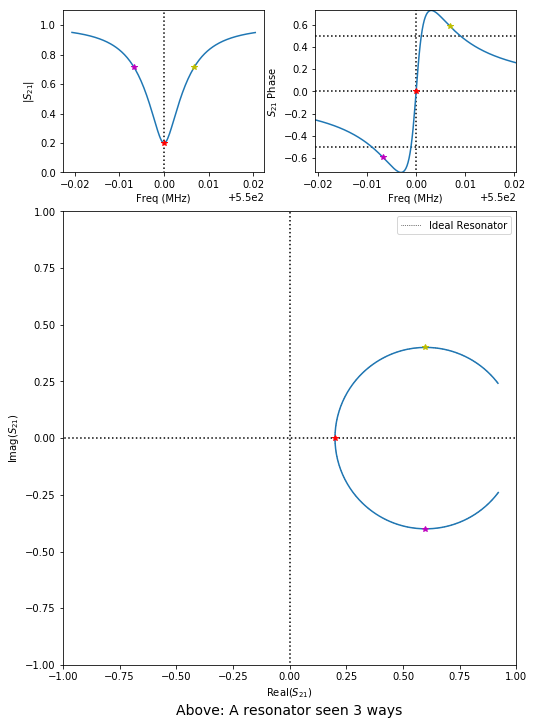

In [3]:
full_res_look(freqs, f_0, Q, ratio_Qc_Qi = Qe_real/Qi, 
              Qe_theta=0, A0 = 1, A1 = 0, tau=0, phi = 0, m = False);

<a id='S-params'></a>
### S-parameters of a Resonator

When we take an $S_{21}$ trace near a resonance, the equation that we are effectively measuring as a function of frequency $\omega = \omega_0 (1 + \delta x)$ is:
$$ S_{21} = 1 - \frac{1 + i\epsilon}{1+i\epsilon \frac{Q}{Q_c}} \frac{Q}{Q_c} \left[ \frac{1}{1+ 2 i Q\delta x/(1+i\epsilon \frac{Q}{Q_c})}\right]$$
$$\approx 1 - \frac{Q}{Q_c}\frac{1}{1 + 2 i Q \delta x}$$ 

This is not really accounting for the feedline (though it does account for the coupling). The last step is assuming $\epsilon\ll 1$. We'll discuss why this isn't quite mathematically equivalent to the complex $Q_e$ paradigm, even for small $\epsilon$ in a future section.

If we want to instead write things in the $Q_e$ paradigm, which puts us closer to before the $\approx$ in the above, then we should write. 
$$ S_{21} \approx 1 - \frac{Q}{Q_e}\frac{1}{1 + 2 i Q\delta x}$$ 

If we do want to account for the rest of the circuit more completely, you'll want to write the more general expression: 
$$\boxed{S_{21} = A(\omega)\left(1 - \frac{Q}{Q_e}\frac{1}{1 + 2 i Q \delta x}\right)}$$

The above is the standard that is perhaps best to use (and is in fact what I use for the most part when fitting resonators). An equivalent way of writing this (but one which will result in different constants and will need to be thought of more carefully) is:

$$ S_{21} = A(\omega)\left(1 - \frac{Q}{Q_c}\frac{1+i \chi}{1 + 2 i Q \delta x}\right)$$

In each of these cases the function $A(\omega)$ is the environmental term that accounts for the rest of the readout chain. We'll discuss that further along with a basic model in a little bit. 

Here's a quick look at a resonator, how the basic parameters impact the shape, and how the S-parameters translate between amplitude and the complex plane. In this, you can even push $Q_e$ to the non-sensical by making it so that $Q_e\lt Q_{total}$. 

Things to notice about the various parameters and how they show up in the complex $S_{21}$ data.

- $f_0$ will generally be the point closest to (0, 0) on the complex resonance circle, though if $Q_e$ is complex, that might not be the case.
- The diameter of the resonant circle is set by $\frac{Q}{Real(Q_e)}$ (as long as the trace has been renormalized to 1 far from $f_0$).
- $Q_{total}$ will determine the spacing between points on the circle as a function of frequency. If you have the same frequency resolution, and increase $Q_{total}$, the points will become more sparse on the side of the circle near $f_0$ and vice versa. This is probably easiest to understand intuitively if you look at the half-max points and notice that they don't change their position on the circle as $Q$ changes, even thouigh they get closer in frequency. 

In [4]:
interact(plot_res_cable, freqs = fixed(freqs), 
         f0=FloatSlider(min=550-1e-2, max=550+1e-2, step=1e-3, value=550), 
         Q=FloatSlider(min=1e4, max=1e5, step=5e3, value=5e4), 
         Qe_real = FloatSlider(min=5e4, max=2e5, step=5e3, value=1.01e5), 
         Qe_theta = fixed(0), 
         A0=fixed(1), A1=fixed(0), tau=fixed(0), phi=fixed(0),
         m=IntSlider(min=1, max=len(freqs)-1,step=1, 
                     value=100));

interactive(children=(FloatSlider(value=550.0, description='f0', max=550.01, min=549.99, step=0.001), FloatSli…

# The Cables, Attenuators, Amplifiers, etc. <a id='Cables'></a>

Now allow me to completely undermine some of what I said about those final equations by acknowledging that we don't really measure either of those scattering parameters. We really measure those features combined with the impacts of the cable, attenuators, amplifiers, etc. Those impact the S-parameters in a complex, frequency-dependent manner so that we wind up with (general cable term) x (resonator term). We've already discussed the essentials of the resonator term (which we'll take most accurately to be the $Q_e$ description), so now let's take a look at the cable term.

As I mentioned, the cable adds a complex, frequency-dependent function which multiplies the resonator term. Assuming that the there are no major features in the trace on a scale similar to a resonator (which is generally the case, but which we'll briefly discuss at the end), that term can generally be written like so:

$$ S_{21}^{cable} = A(\omega ) = \left( A_0 + A_1\delta f \right)e^{-i(2\pi \delta f\tau + \phi)}$$

In this case, $\delta f \equiv f-f_0$,$A_0$, $A_1$, $\tau$, and $\phi$ are constants that we need to fit.$^{**}$ Physically, we can think of $\lvert S_{21} \rvert$ as a normalization of the trace to account for the frequency-dependent loop gain (i.e. total gain from amplifiers minus attenuation of the circuit), and exp$[-i(2\pi \delta f\tau + \phi)]$ (i.e. the phase term) as a phase-offset that comes from the fact that the circuit appears to be a different length at different wavelengths. In each part of the equation (the amplitude and the phase), we have a constant that represents an arbitrary overall offset ($A_0$ and $\phi$) for when $\delta f = 0$, and then we have an additional offset that quantifies how quickly the amplitude or phase evolves as a function of the frequency ($A_1$ and $2\pi\tau$).
    
<br>
<br>
\*\* *Note that this equation is written slightly differently in the code as*

$$ S_{21}^{cable} = A_0\left(1 + A_1\delta f' \right) e^{-i(2\pi \delta f'\tau + \phi)}$$

*where $\delta f'\equiv f-f_{min}$ with $f_{min}$ being the minimum frequency in your sweep. This is essentially equivalent to what I've written above and is particularly a better parametrization when we have more than one resonator (i.e. more than one $f_0$) or no resonators. It does, however, make it a bit harder to physically interpret the fitting parameters and to understand what they do to a resonator.* 

*For that reason, I'll generally try to write things such that $\delta f\equiv f-f_0$ when I'm writing things with a resonator and $\delta f\equiv f-f_{min}$ when there is no resonator involved. This is really a pretty minor point, but just in case someone other than me is reading this and notices any discrepancies, it probably has to do with that. * 


<br>
<br>
So what does this look like without a resonator? ($\delta f\equiv f-f_{min}$)

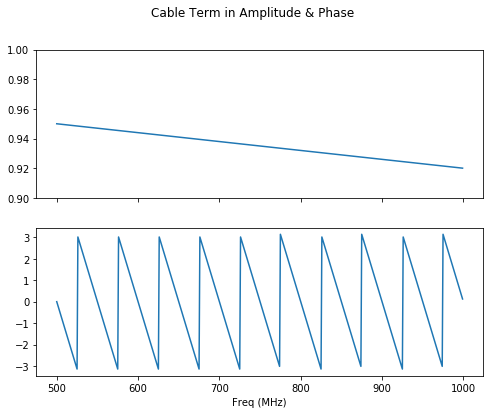

In [5]:
fs = np.arange(500, 1000)#A frequency sweep from 500 MHz to 1 GHz
A0 = 0.95
A1 = -0.03/500
tau = 1/50
phi = 0

general_cable = res.general_cable(f = fs, 
                                  delay = tau, 
                                  phi = phi,
                                  f_min = fs[0],
                                  A_mag = A0, 
                                  A_slope = A1/A0)

fig,ax=plt.subplots(2,figsize = (8,6), sharex=True)
fig.suptitle("Cable Term in Amplitude & Phase")

ax[0].plot(fs, np.abs(general_cable)); ax[0].set_ylim(0.9, 1)

ax[1].plot(fs, np.angle(general_cable))

ax[1].set_xlabel('Freq (MHz)')
plt.show()

And here's the same thing combined into a plot of both it's real and complex components. Scrub the slider to sett how much of the sweep you want to include from 500 MHz to (500 + n) MHz.

In [6]:
interact(plot_cable, n=IntSlider(min=1, max=500, step=1, value=500), 
         A0 = FloatSlider(min=0.6, max=1, step=.05, value=0.95), 
         A1 = FloatSlider(min=-1e-3, max=1e-3, step=4e-5, value=-6e-5, 
                          readout_format='.5f'),
         tau=FloatSlider(min=-0.3, max=0.3, step=0.02, value=0.02),
         phi=FloatSlider(min=-np.pi, max=np.pi, step=np.pi/10, 
                         value=0.0));

interactive(children=(IntSlider(value=500, description='n', max=500, min=1), FloatSlider(value=0.95, descripti…

### Combining Cables & Resonators <a id='Cab_res'></a>
Before moving on, let's take a look at the effects of a cable on a resonator. Here we'll see how the cable and the rest of the environment shifts the resonance circle around, meaning I'll be writing everything such that $\delta f\equiv f-f_0$. Notice that they have the following effects:

- $A_0$ just shifts the overall amplitude of everything and shrinks the resonator circle inward. 
- $A_1$ can add a potentially noticable slope to the amplitude, but more significantly, it adds an asymettry to the resonant circle.
- $\tau$ is sort of like taking the two ends of the resonant circle on either side of $f_0$ and pulling them tight. When $\phi = 0$ and $Q_e$ is entirely real, $\tau$ will slightly deform the circle such that $S_{21}$ will become completely real again at $f = f_0 \pm \frac{1}{2\tau}$.
- $\phi$ rotates the entire circle in the complex plane. If you have a resonator with $Q_e$ entirely real, then $\phi$ is simply the angle between your resonant circle at $f_0$ and the positive x-axis. 

A good detail to notice is that $A_0$ and $A_1$ can be fitted by purely using the amplitude information, especially away from the resonance. Meanwhile, changes in $tau$ and $phi$ leave the amplitude completely unaffected (which is to be expected), meaning that we can only fit for them if we have the full complex $S_{21}$ data. In all cases, we're best off fitting these parameters far away from a resonator.

**Note on $\tau$ for only this plot:** *In general, $\tau$ will only ever positive, though I've left the option of making $\tau$ negative in this plot so that you can see what it does. If $\tau\lt 0$ in a real plot then you are looking at, then it is very likely that you either have a calibration error, or that your resonator is sitting in the middle of much broader resonance that is dominated by its own $Q_c$. Either situation is bad for your resonator and should probably be addressed.*


In [7]:
#res params
f0 = 550
Q = 5e4
Qe_real = 6e4
Qe_theta = 0
    
#frequency sweep
br = f0/(2*Q)
n = 400
freqs = np.arange(f0 - 12*br, f0 + 12*br, 24*br/n)

In [8]:
interact(plot_res_cable, freqs = fixed(freqs), f0 =fixed(f0), 
         Q = fixed(Q), Qe_real = fixed(Qe_real), 
         Qe_theta = fixed(Qe_theta), 
         A0 = FloatSlider(min=0.6, max=1, step=.05, value=1), 
         A1 = FloatSlider(min=-2, max=2, step=.1, value=0),
         tau=FloatSlider(min=-2, max=2, step=0.2, value=0.0),
         phi=FloatSlider(min=-np.pi, max=np.pi, step=np.pi/10, 
                         value=0.0),
         m = fixed(False));

interactive(children=(FloatSlider(value=1.0, description='A0', max=1.0, min=0.6, step=0.05), FloatSlider(value…

# Why is $Q_e$ complex and what does it do? <a id='Q_e'></a>

Since the effects of $f_0$ and $Q$ on a trace are pretty straight forward, let's look at the effects of changing $Q_e$ in terms of both its contribution to $Q$ and its complexity. First we'll start by looking at the contributions of $Q_e$ to total $Q$ and how that impacts the trace. For now, we'll keep $Q_e$ completely real, making it's description exactly equivalent to $Q_c$ with $\epsilon\ll1$.  

We'll start with those things that are fixed.

In [9]:
#params
f_0 = 550
Q = 1e5
br = f_0/(2*Q)
n = 200
freqs = np.arange(f_0 - 3*br, f_0 + 3*br, 6*br/n)

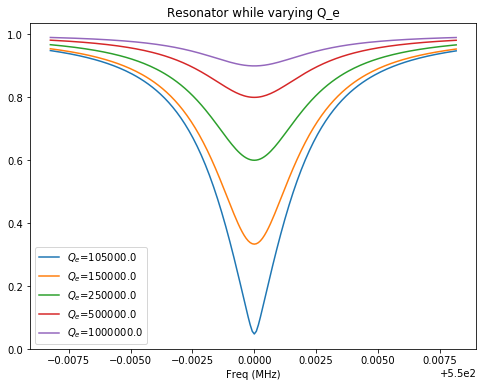

In [10]:
Qe_mag = [1.05e5,1.5e5, 2.5e5, 5e5, 1e6] 
Qe_angle = 0

plt.figure(figsize=(8,6))
plt.title(f"Resonator while varying Q_e")
plt.xlabel('Freq (MHz)')

for Qem in Qe_mag:
    Qe= Qem*(np.cos(Qe_angle) + 1j*np.sin(Qe_angle))
    res1 = res.linear_resonator(freqs, f_0, Q, np.real(Qe),
                                np.imag(Qe))
    plt.plot(freqs, np.abs(res1), label = f'$Q_e$={Qem}')
    
plt.legend(loc=0)
plt.show()

A few things to notice:

- Changing the angle $\theta$ in $Q_e$ not only rotates the circle about the point (1,0), but also resizes the circle by $cos\theta$. This means the full relation of the diameter $D$ to the $Q$ factors is $D sec\theta = \frac{Q}{Real(Q_e)}$.
- The "half-max" points, which are positioned at points $\pm\frac{\pi}{2}$ from $f_0$ on the resonant circle, don't change in frequency as $Q_e$ changes (though they do change from being "half-max" in amplitude when $\theta\ne 0$).
- The minimum of the resonator is not generally $f_0$ when $\theta\ne 0$, but will instead be at:

$$ \delta x = \frac{cot\theta}{2 Q} + \frac{csc\theta}{4}\left(-\frac{1}{Q_e} - \sqrt{Q_e^{-2} - \frac{4 cos\theta}{Q Q_e} + 4 Q^{-2}}\right)$$

Good luck making physical sense out of that equation. I'm only writing it because I took the time to figure it out. It's probably correct, but it's also not really a useful equation to know. Please forget it now.

In [11]:
interact(plot_Qe, freqs = fixed(freqs), 
         f0=fixed(f_0), 
         Q=fixed(1e5),
         Qe_real = FloatSlider(min=1.1e5, max=1e6, step=1e4, 
                               value=1.1e5), 
         Qe_theta = FloatSlider(min=-90, max=90, step=5, value=0.0), 
         A0=fixed(1), A1=fixed(0), tau=fixed(0), phi=fixed(0), 
         m = fixed(False));

interactive(children=(FloatSlider(value=110000.0, description='Qe_real', max=1000000.0, min=110000.0, step=100…

And now, what if we incorporate the changes that come from the environment and see how those interact with complex changes in $Q_e$?

In [12]:
#res params
f0 = 550
Q = 5e4
Qe_real = 6e4
    
#frequency sweep
br = f0/(2*Q)
n = 400
freqs = np.arange(f0 - 12*br, f0 + 12*br, 24*br/n)

interact(plot_res_cable, freqs = fixed(freqs), f0 =fixed(f0), 
         Q = fixed(Q), Qe_real = fixed(Qe_real), 
         Qe_theta = FloatSlider(min=-90, max=90, step=5, 
                         value=0.0), 
         A0 = FloatSlider(min=0.6, max=1, step=.05, value=1), 
         A1 = FloatSlider(min=-2, max=2, step=.1, value=0),
         tau=FloatSlider(min=0, max=2, step=0.2, value=0.0),
         phi=FloatSlider(min=-np.pi, max=np.pi, step=np.pi/10, 
                         value=0.0),
         m = fixed(False));

interactive(children=(FloatSlider(value=0.0, description='Qe_theta', max=90.0, min=-90.0, step=5.0), FloatSlid…

And one more version of the above, just to show explicitly how these things affect the phase vs. the amplitude.

In [13]:
interact(plot_res_phase, freqs = fixed(freqs), f0 =fixed(f0), 
         Q = fixed(Q), Qe_real = fixed(Qe_real), 
         Qe_theta = FloatSlider(min=-90, max=90, step=5, 
                         value=0.0), 
         A0 = FloatSlider(min=0.6, max=1, step=.05, value=1), 
         A1 = FloatSlider(min=-2, max=2, step=.1, value=0),
         tau=FloatSlider(min=0, max=2, step=0.2, value=0.0),
         phi=FloatSlider(min=-np.pi, max=np.pi, step=np.pi/10, 
                         value=0.0),
         m = fixed(False));

interactive(children=(FloatSlider(value=0.0, description='Qe_theta', max=90.0, min=-90.0, step=5.0), FloatSlid…

## A brief look at $\epsilon$ vs. $Q_e$ <a id='eps_v_Q_e'></a>

Remember before when we wrote the equations:

$$ S_{21} = 1 - \frac{1 + i\epsilon}{1+i\epsilon \frac{Q}{Q_c}} \frac{Q}{Q_c} \left[ \frac{1}{1+ 2 i Q\delta x/(1+i\epsilon \frac{Q}{Q_c})}\right]$$

and we also wrote:

$$S_{21 }\approx 1 - \frac{Q}{Q_e}\frac{1}{1 + 2 i Q \delta x}$$

Well, let's take a moment to see just how these two descriptions differ. Here's a look at the effects of varying $\epsilon$. We can clearly see the relationship between it and the asymmetry of the trace.

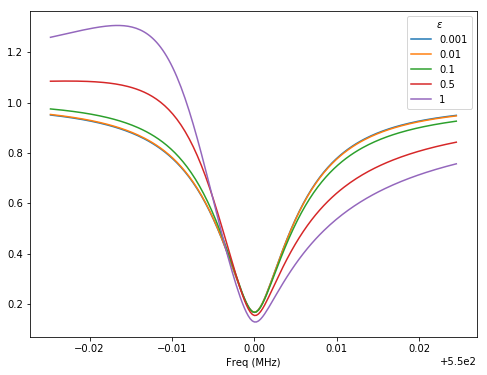

In [14]:
#Effects of epsilon
f0, Qi, Qc = 5.5e8, 2e5, 4e4
Q = (Qi**-1 + Qc**-1)**-1
br = f0/(2*Q)
n = 200
freqs = np.arange(f0 - 3*br, f0 + 3*br, 6*br/n)

eps = [0.001, 0.01, 0.1,0.5, 1]

plt.figure(figsize=(8,6)); plt.xlabel('Freq (MHz)')

for ep in eps:
    s21 = S21(freqs, Qi, Qc, ep, f0)
    plt.plot(freqs*1e-6, np.abs(s21), label = ep)
    
plt.legend(title="$\epsilon$", loc=0)
plt.show()

Now compare that to a similar plot generated by shifting the angle of $Q_e$ but keeping $Q_{total}$ fixed.

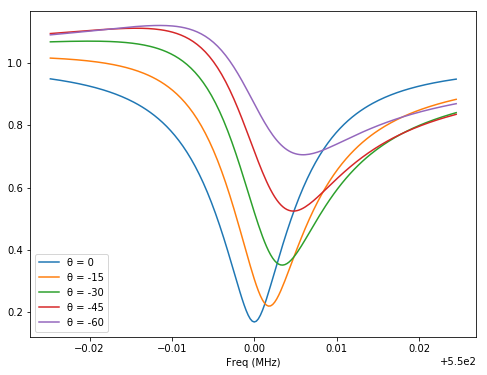

In [15]:
#Effects of the angle of Qe 
Qe_real = 4e4
Qe_angle = [0, -15, -30, -45, -60]

plt.figure(figsize=(8,6)); plt.xlabel('Freq (MHz)')

theta_unicode = "\u03B8"

for Qea in Qe_angle:
    theta = np.deg2rad(Qea)
    Qe= Qe_real*(1 + 1j*np.tan(theta))
    res1 = res.linear_resonator(freqs, f0, Q, Qe_real, np.imag(Qe))
    plt.plot(freqs*1e-6, np.abs(res1),
             label=f'{theta_unicode} = {Qea}')
    
plt.legend(loc=0)
plt.show()

Or if you prefer, we can look at that in complex space.

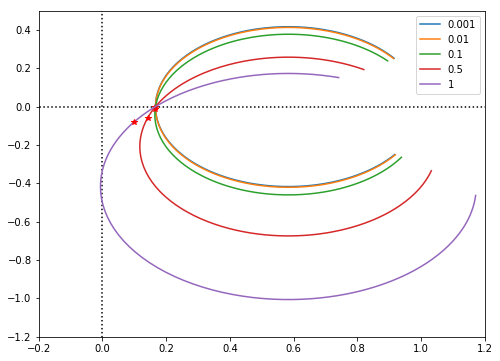

In [16]:
plt.figure(figsize=(8,6));

for ep in eps:
    s21 = S21(freqs, Qi, Qc, ep, f0)
    s = S21(f0, Qi, Qc, ep, f0)
    plt.plot(np.real(s21), np.imag(s21), label = ep)
    plt.plot(np.real(s), np.imag(s), 'r*')
    

plt.xlim(-0.2,1.2); plt.ylim(-1.2, 0.5)
plt.vlines(0,-4, 4, linestyles='dotted')
plt.hlines(0,-4, 4,linestyles='dotted')
plt.legend(loc=0); plt.show()

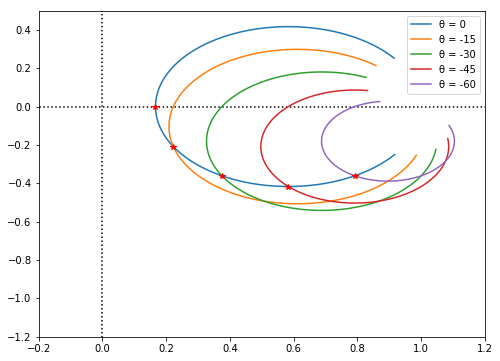

In [17]:
plt.figure(figsize=(8,6));

for Qea in Qe_angle:
    theta = np.deg2rad(Qea)
    Qe= Qe_real*(1 + 1j*np.tan(theta))
    res1 = res.linear_resonator(freqs, f0, Q, Qe_real, np.imag(Qe))
    plt.plot(np.real(res1), np.imag(res1), 
             label=f'{theta_unicode} = {Qea}')
    plt.plot(np.real(res1[100]), np.imag(res1[100]), 'r*')
    
plt.xlim(-0.2,1.2); plt.ylim(-1.2, 0.5)
plt.vlines(0,-4, 4, linestyles='dotted')
plt.hlines(0,-4, 4,linestyles='dotted')
plt.legend(loc=0); plt.show()

Between these two interpretations, we can clearly see that the two representations of the asymmetry of the resonator are not equivalent and that the $\epsilon$ representation is changing the plot in a way that doesn't really retain the same $Q_{total}$ or $f_0$, though it does retain $f_0$ as the point of maximum dip depth in the trace. While this difference doesn't really matter for nearly symmetric resonators or those where the rotation and rescaling of the resonant circle has been accounted for by some other method, it does require some consideration. 

For these reasons, I'll stick with the $Q_e$ description, and where I've referred to $Q_c$ that can be treated as Real($Q_e$), to which it is roughly equivalent. 

## The importantance of  $Q_c$ vs. $Q_i$<a id='Qi_v_Qe'></a>


Next, let's look at the relationship between $Q_i$, $Q_c$, and total $Q$, which derives from the equation:

$$ \frac{1}{Q} = \frac{1}{Q_i} + \frac{1}{Q_c} $$

For the purposes of analyzing this relationship, it's easier to parametrize $Q_c$ in terms of $Q_i$ as $Q_c = r Q_i$ and $Q_i$ as $Q_i = (1 - \delta) Q_i$, an intrinsic $Q_i$ plus or minus some fractional shift as a result of photon-loading. This makes it easier to see the way that photon loading affects our resonator in different regimes. 

By moving the sliders around below we see the relationship between shifts in $Q_i$ and shifts in total $Q$ as a function of the ratio $r=Q_c$/$Q_i$. When $Q_c\ll Q_i$ then the total $Q$ is dominated by $Q_c$ and even a massive shift in $Q_i$ brings only a very tiny shift in total $Q$. Conversely when $Q_c\gg Q_i$, the total $Q$ becomes dominated by $Q_i$ and any shift in $Q_i$ leads to a roughly equal shift in $Q$.

In [18]:
#Fixing Q_total to be 30,000 and adjusting Q_i based on
#r to maintain that

interact(plot_Q_shifts,
         r_exp=FloatSlider(min=-2, max=2, step=0.2, value=0.0));

interactive(children=(FloatSlider(value=0.0, description='r_exp', max=2.0, min=-2.0, step=0.2), Output()), _do…

In [19]:
interact(plot_Q_shifts_S,
         r_exp=FloatSlider(min=-2, max=2, step=0.2, value=0.0));

interactive(children=(FloatSlider(value=0.0, description='r_exp', max=2.0, min=-2.0, step=0.2), Output()), _do…

What are the important considerations when looking at total $Q$ and the relationship between $Q_c$ and $Q_i$?

If $Q_c$ is too large, such that the total $Q$ is dominated by $Q_i$ than the loading can cause the resonator to spread out so much that we see a large increase in collisions between nearby resonators. Meanwhile, if $Q_c$ is too much smaller than $Q_i$, such that total $Q$ is dominated by $Q_c$, then the resonator becomes to sensitive to readout easily (without significant overhead for tone-tracking). A significant shift in $f_0$ will move the resonator far enough that our probe tone is no longer in a sensitive part of the resonance.  

 <a id='OtherStuff'></a>
 # Note on all the stuff the above doesn't capture

There are many things that I haven't described here, some of which I'll try to describe in a future notebook. Some of those things are outside of the scope of what I've attempted to describe here (noise, impacts of microscopic physics on resonators, how you actually read out or fit a resonator, etc.), but there are some other things that one might see when looking at real data from a signal analyzer, VNA, ROACH-2, SMuRF, etc. I'd like to briefly touch on a few of those things. 

The biggest thing I'll say is that S-parameters are seldom quite as clean as I've shown here. There's always some noise, of course, but more than that there are other features that will appear in your trace that prevent it from looking like $A(f)$ that I've shown above on larger scales. These can include spurious resonances (from things like box-modes or resonant cavities, for example) that are generally much lower $Q$ than any true resonators. They can also include standing waves, which look like a sine wave has been added to your trace. These come from sections of your readout chain where heavy reflections add or subtract coherently to impact the attenuation.

With any luck (and as is quite often the case), any other features will be broad enough in their frequency response in comparison to any given resonator that they can be approximated in some region near the resonance quite well by the description I've given above. It's thanks to these other features, that we can't expect for $A(f)$ to have the same constants for all resonators, though they ought to be relatively similar in most cases.

The other thing that I'll mention here, is that I haven't mentioned tone-power at all here. That affects the noise, as will discussed in another notebook, but can also impact the resonator shape. If we try to ring the resonator with too much power, the resonator will be driven into a non-linear regime. When a resonator goes non-linear the shape becomes asymmetrical. If the resonator is only slightly non-linear, this can look like $Q_e$ in action, and may cause you to overestimate the $Q$. A highly non-linear resonator will become unuseably sensitive on one side. This can make it look a bit like a shark tooth in an amplitude plot, or as if the resonant circle has been dropped from very high on one side. Either way, this means you need to back off the power a bit. Hopefully, I'll find time to discuss this a bit more in detail in the future. 

# Final Bit of Fun <a id='Final'></a>

We'll finish up with one more slider-straveganza. In this last one, I've put a slider on all of what are perhaps the most impactful parameters and tried to stick to make it as physically sensible as possible. I'm also simultaneously showing the impact on phase, amplitude, and complex $S_{21}$. The biggest difference between this and when we were looking at $Q_e$ is that I've replaced the parameter Real$(Q_e)$ with the ratio of the coupling quality factor to the internal quality factor. From this and the phase of $Q_e$ we can easily recover $Q_i$ and $Q_e$, but if we want to fix $Q$ and $f_0$, this is the only sensible knob that we can turn.

In [20]:
#res params
f0 = 550
Q = 5e4
Qe_real = 6e4
    
#frequency sweep
br = f0/(2*Q)
n = 200
freqs = np.arange(f0 - 12*br, f0 + 12*br, 24*br/n)

In [21]:
interact(full_res_look, freqs = fixed(freqs), f0 =fixed(f0), 
         Q = FloatSlider(min=3e4, max=1e5, step=5e3, value=5e4), 
         ratio_Qc_Qi= FloatLogSlider(value=0.1, base=10, min=-3, max=3, 
                                     step=.25), 
         Qe_theta = FloatSlider(min=-80, max=80, step=5, 
                         value=0.0), 
         A0 = FloatSlider(min=0.6, max=1, step=.05, value=1), 
         A1 = FloatSlider(min=-2, max=2, step=.1, value=0),
         tau=FloatSlider(min=0, max=2, step=0.2, value=0.0),
         phi=FloatSlider(min=-np.pi, max=np.pi, step=np.pi/10, 
                         value=0.0),
         m = fixed(False));

interactive(children=(FloatSlider(value=50000.0, description='Q', max=100000.0, min=30000.0, step=5000.0), Flo…

# References & Recommended Readings <a id='References'></a>
<br>

### **General Superconducting Detector Reviews**
Probably the best place to start if you're learning this stuff for detectors.


[**Transition Edge Sensors and Kinetic Inductance Detectors in Astronomical Instruments** - P.D. Mauskopf](https://iopscience.iop.org/article/10.1088/1538-3873/aabaf0/meta) *A ton of useful information on both TESes and KIDs along with a healthy amount of resonators.*

[**Superconducting Microresonators: Physics and Applications** - J. Zmuidzinas](https://www.annualreviews.org/doi/abs/10.1146/annurev-conmatphys-020911-125022) *Good in-depth review. You may want to read it.*

<br>

### **Textbooks**
Particularly useful for detailed background on the subjects in this notebook.

[**Microwave Engineering** - D.M. Pozar](https://newcatalog.library.cornell.edu/catalog/3071617) *When I first met Sam Gordon and asked him various questions about KIDs and KID readout, he asked me if I had read the Bible yet, referring to this book. Then he sent me a pdf of it. I've convinced two separate office-mates to buy this so that I have a copy in my office. I really should just buy a copy at some point.*

[**The Art of Electronics** - P. Horowitz & W. Hill](https://newcatalog.library.cornell.edu/catalog/8886155) *You should own this book. It is massive. It is beautiful.*

[**Understanding Digital Signal Processing** - Richard Lyons ](https://www.pearson.com/us/higher-education/program/Lyons-Understanding-Digital-Signal-Processing-3rd-Edition/PGM202823.html) *We don't have this book in our library for some reason, but it's pretty good, in particular for readout related things.*

<br>

### **Theses**
A few relevant theses that have a lot of good stuff and a lot of irrelevant stuff.

[**Microwave Kinetic Inductance Detectors** - B.A. Mazin](https://thesis.library.caltech.edu/3910/1/MazinThesis.pdf) *"Gee, that sure is a generic title." The original MKID thesis from 2004.*

[**The Physics of Superconducting Microwave Resonators** - J. Gao](https://thesis.library.caltech.edu/2530/) *This is Jiansong's thesis. I challenge you to find a paper on KID noise or measurements with more than a handful of citations that doesn't reference this. It's more detailed than you need.*

[**Highly Multiplexed Superconducting Detectors and Readout Electronics for Balloon-Borne and Ground-Based Far-Infrared Imaging and Polarimetry** - S. Gordon](https://repository.asu.edu/items/54975) *Detailed discussion of detectors and readout for BLAST-TNG. Highly relevant for CCAT-prime.*

<br>

### **Detailed Resonator Analysis Papers**
Nitty gritty details

[**An analysis method for asymmetric resonator transmission applied to superconducting devices** - M.S. Khalil, et al](https://arxiv.org/abs/1108.3117) *A detailed look at resonators from the perspective of what causes asymmetry and how best to account for that when fitting.*

[**Coplanar waveguide resonators for circuit quantum electrodynamics** - M. G&ouml;ppl, et al](https://qudev.phys.ethz.ch/static/content/science/papers/Goeppl2008_JAP.pdf) *Most useful for the extensive discussion of coupling.*

<br>
<br>


## Teaser for future notebook: Resonators as functions of circuit parameters

Now let's look at the ways that a shift in the base circuit parameters effect a resonator

In [22]:
Qc = 4e4
Qi = 1e5
Qr = (Qi**-1 + Qc**-1)**-1
dmax = 2*(Qr-2)*(Qr-1)**-2

interact(shift_LR_plot, del_L=FloatSlider(min=0, max=dmax, 
                                         step=dmax/10, value=0.0),
         del_R=FloatSlider(min=0, max=4, 
                                         step=0.5, value=0.0),
         IQ=["Magnitude","IQ"]);

interactive(children=(FloatSlider(value=0.0, description='del_L', max=6.9999999914244e-05, step=6.999999991424…